# Предиктивная система предупреждения отказов силовых трансформаторов с выбросом (возгоранием) масла и оценки технического состояния трансформаторов

### Описание поставленной задачи и набора данных

Силовые трансформаторы - чрезвычайно важный и дорогостоящий элемент энергосистемы, обеспечивающий преобразование напряжения и тока с сохранением частоты и без изменения передаваемой мощности (без учета потерь). В случае выхода мощного силового трансформатора из строя с выбросом/возгоранием масла и отсутствия аналогичного оборудования в аварийном запасе, длительность изготовления нового трансформатора и его ввода в работу взамен поврежденного составляет не менее нескольких месяцев, а стоимость исчисляется сотнями миллионов рублей. Это предопределяет особую важность контроля за техническим состоянием силовых трансформаторов в целях предупреждения таких повреждений.

**Цели работы:**

1) Обучение и оценка моделей заблаговременного определения (предсказания)  срабатывания сигнализатора уровня масла в баке на основании данных о контролируемых параметрах силовых трансформаторов.

2) Предсказание общего индекса технического состояния (ИТС) силовых трансформаторов на основании контролируемых параметров.

**Краткое описание признаков датасетов Overview и CurrentVoltage:**
- OTI - индикатор (датчик) температуры масла
- WTI - индикатор (датчик) температуры обмоток
- ATI - индикатор (датчик) температуры окружающей среды
- OLI - указатель уровня масла
- OTIA - сообщение индикатора (датчика) температуры масла
- OTIT - срабатывание индикатора (датчика) температуры масла
- MOG_A - сигнализатор уровня масла в баке - *целевой признак*
- VL1 - фазное напряжение 1
- VL2 - фазное напряжение 2
- VL3 - фазное напряжение 3
- IL1 - ток фазы 1
- IL2 - ток фазы 2
- IL3 - ток фазы 3
- VL12 - междуфазное напряжение 1-2
- VL23 - междуфазное напряжение 2-3
- VL31 - междуфазное напряжение 3-1
- INUT - ток нейтрали
- Данные собраны с интервалом 15 минут в течение 10 месяцев 2019-2020 гг.


**Краткое описание полей датасета Health_index:**
- Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,,Interfacial V,Dielectric rigidity,Water content - контролируемые параметры состояни силовых трансформаторов (значение ясно из названия параметров)
- DBDS - Дибензилдисульфид
- Power factor - показатель, характеризующий вторичную нагрузку (величину, угол сопротивления) 
- Health index - индекс технического состояния (ИТС) - *целевой признак (измеряется от 0 до 100)*

### Загрузка библиотек

In [175]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as Xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix

### Задача 1. Заблаговременное определение (предсказание) срабатывания сигнализатора уровня масла в баке

#### Загрузка данных

In [176]:
df1 = pd.read_csv('Overview.csv')
df1.head(3)

,DeviceTimeStamp,OTI,WTI,ATI,OLI,OTI_A,OTI_T,MOG_A
0,2019-06-25T13:06,0.0,0.0,0.0,37.0,0.0,0.0,0.0
1,2019-06-25T13:09,0.0,0.0,0.0,37.0,0.0,0.0,0.0
2,2019-06-27T10:49,0.0,0.0,0.0,38.0,0.0,0.0,0.0


In [177]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20316 entries, 0 to 20315
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DeviceTimeStamp  20316 non-null  object 
 1   OTI              20316 non-null  float64
 2   WTI              20316 non-null  float64
 3   ATI              20316 non-null  float64
 4   OLI              20316 non-null  float64
 5   OTI_A            20316 non-null  float64
 6   OTI_T            20316 non-null  float64
 7   MOG_A            20316 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.2+ MB


In [178]:
# перевод первого столбца в datetime
df1['DeviceTimeStamp'] = pd.to_datetime(df1['DeviceTimeStamp'], format='%Y-%m-%d %H:%M:%S')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20316 entries, 0 to 20315
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DeviceTimeStamp  20316 non-null  datetime64[ns]
 1   OTI              20316 non-null  float64       
 2   WTI              20316 non-null  float64       
 3   ATI              20316 non-null  float64       
 4   OLI              20316 non-null  float64       
 5   OTI_A            20316 non-null  float64       
 6   OTI_T            20316 non-null  float64       
 7   MOG_A            20316 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.2 MB


In [179]:
df2 = pd.read_csv('CurrentVoltage.csv')
df2.head(3)

,DeviceTimeStamp,VL1,VL2,VL3,IL1,IL2,IL3,VL12,VL23,VL31,INUT
0,2019-06-25T13:06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-06-27T10:49,238.7,238.7,238.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-06-27T10:51,238.4,238.5,238.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
# перевод первого столбца в datetime
df2['DeviceTimeStamp'] = pd.to_datetime(df2['DeviceTimeStamp'], format='%Y-%m-%d %H:%M:%S')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19352 entries, 0 to 19351
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DeviceTimeStamp  19352 non-null  datetime64[ns]
 1   VL1              19352 non-null  float64       
 2   VL2              19352 non-null  float64       
 3   VL3              19352 non-null  float64       
 4   IL1              19352 non-null  float64       
 5   IL2              19352 non-null  float64       
 6   IL3              19352 non-null  float64       
 7   VL12             19352 non-null  float64       
 8   VL23             19352 non-null  float64       
 9   VL31             19352 non-null  float64       
 10  INUT             19352 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.6 MB


In [181]:
# объединение датафреймов по отметке времени
df = pd.merge(df1, df2, how='inner', on='DeviceTimeStamp')
df.isnull().sum()

DeviceTimeStamp    0
OTI                0
WTI                0
ATI                0
OLI                0
OTI_A              0
OTI_T              0
MOG_A              0
VL1                0
VL2                0
VL3                0
IL1                0
IL2                0
IL3                0
VL12               0
VL23               0
VL31               0
INUT               0
dtype: int64

In [182]:
df.duplicated().value_counts()

False    19484
True       981
dtype: int64

In [183]:
df.drop_duplicates(inplace=True)
df.shape

(19484, 18)

#### Визуализация данных

In [184]:
# настройка параметров визуализации
plt.rcParams['figure.figsize'] = (15,6) 
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["axes.titleweight"] = 'normal'
plt.rcParams['axes.titlelocation'] = 'center' 
plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelcolor"] = 'Gray'
plt.rcParams["xtick.bottom"] = True 
plt.rcParams['xtick.color'] = 'Gray'
plt.rcParams["ytick.left"] = True  
plt.rcParams['ytick.color'] = 'Gray'
plt.rcParams['legend.loc'] = 'best' 
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['font.size'] = 13
plt.rcParams['axes.grid'] = True 
plt.rcParams['grid.color'] = 'Gray'
plt.rcParams['grid.linewidth'] = .3
plt.rcParams['grid.alpha'] = .5   

Text(43.70715, 0.5, 'Температура масла')

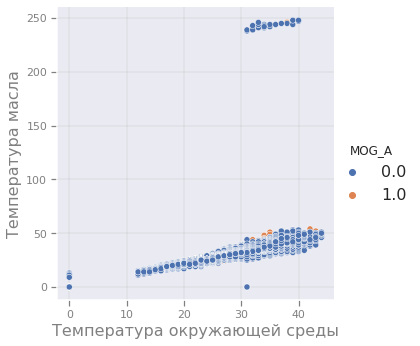

In [185]:
# Распределение взаимосвязи температуры масла (OTI) и температуры окружающей среды (ATI)
# с детализацией по статусу срабатывания сигнализатора уровня масла (MOG_A)

sns.relplot(data=df, x="ATI", y="OTI", hue="MOG_A")
plt.xlabel('Температура окружающей среды')
plt.ylabel('Температура масла')

Text(6.414999999999999, 0.5, 'Температура масла')

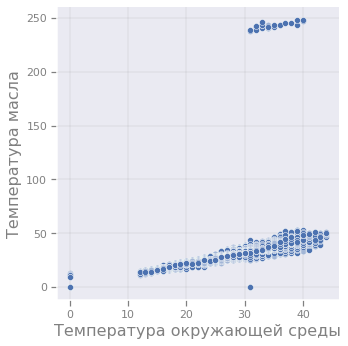

In [186]:
# отдельно по MOG_A = 0:

sns.relplot(data=df[df['MOG_A'] == 0], x="ATI", y="OTI")
plt.xlabel('Температура окружающей среды')
plt.ylabel('Температура масла')

Text(6.414999999999999, 0.5, 'Температура масла')

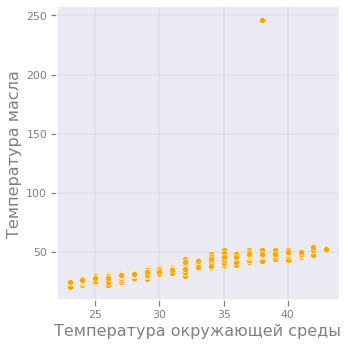

In [187]:
# отдельно по MOG_A = 1:

sns.relplot(data=df[df['MOG_A'] == 1], x="ATI", y="OTI", color='orange')
plt.xlabel('Температура окружающей среды')
plt.ylabel('Температура масла')

Все случаи аномально высокой температуры масла (за исключением одного) соответствуют несработавшему индикатору температуры обмоток

Text(0, 0.5, 'Температура (град. Цельсия)')

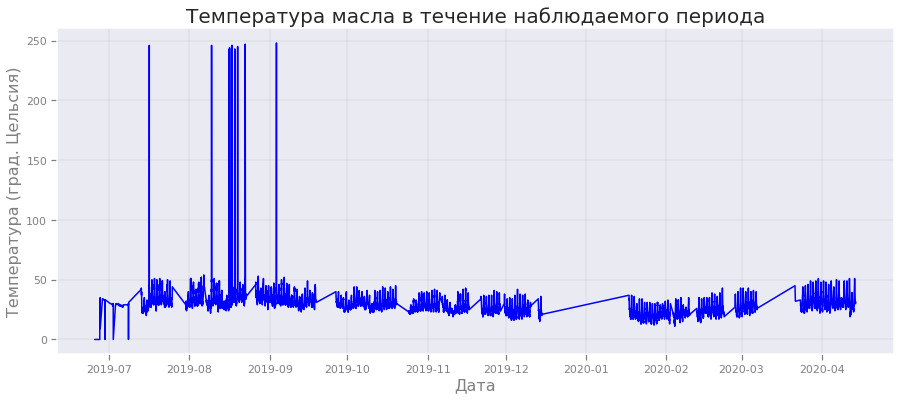

In [188]:
# Температура масла в течение наблюдаемого периода:
plt.plot(df['DeviceTimeStamp'], df['OTI'], color='blue')
plt.title('Температура масла в течение наблюдаемого периода')
plt.xlabel('Дата')
plt.ylabel('Температура (град. Цельсия)')

Зафиксированы аномальные скачки температуры масла в июле-сентябре 2019 г.

Text(0, 0.5, 'Уровень масла (см)')

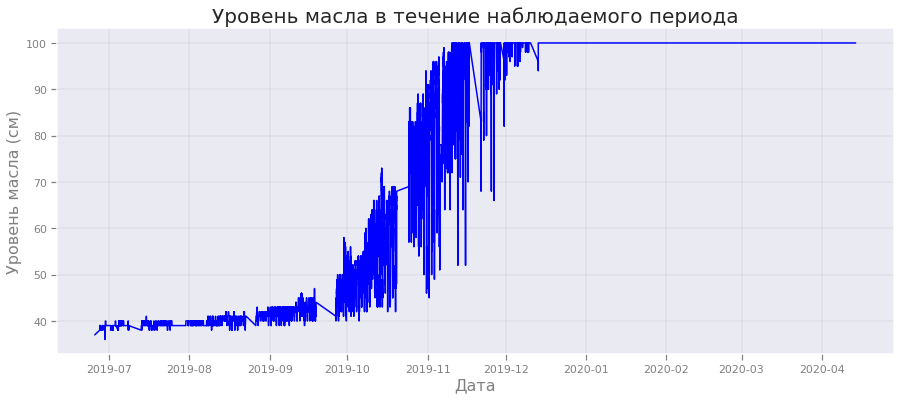

In [189]:
# Уровень масла в течение наблюдаемого периода:
plt.plot(df['DeviceTimeStamp'], df['OLI'], color='blue')
plt.title('Уровень масла в течение наблюдаемого периода')
plt.xlabel('Дата')
plt.ylabel('Уровень масла (см)')

Зафиксирован рост уровня масла с сентября-октябрья 2019 г., что может быть связано с доливкой масла, повышением температуры окружающей среды, повышением уровня загрузки транформатора, некорректной работой датчика

Text(0, 0.5, 'Температура окружающей среды, град. Цельсия')

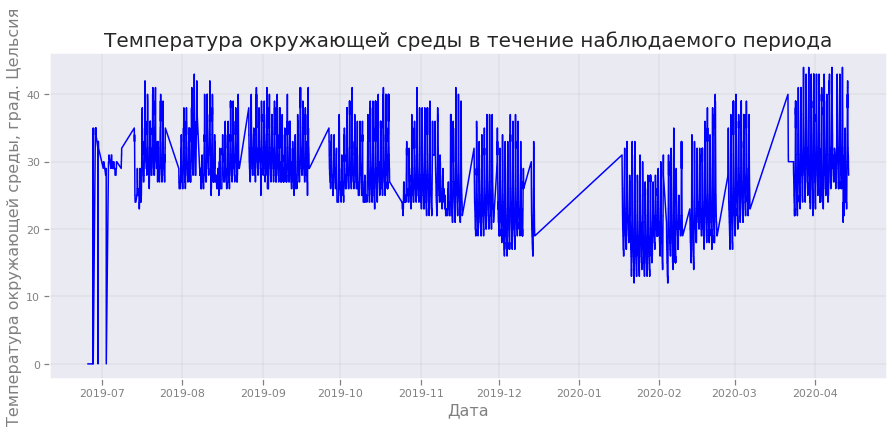

In [190]:
# Температура окружающей среды в течение наблюдаемого периода:
plt.plot(df['DeviceTimeStamp'], df['ATI'], color='blue')
plt.title('Температура окружающей среды в течение наблюдаемого периода')
plt.xlabel('Дата')
plt.ylabel('Температура окружающей среды, град. Цельсия')

Гипотеза о повышении уровня масла из-за повышения температуры окружающей среды не подтверждается

Text(0, 0.5, 'Статус датчика температуры масла')

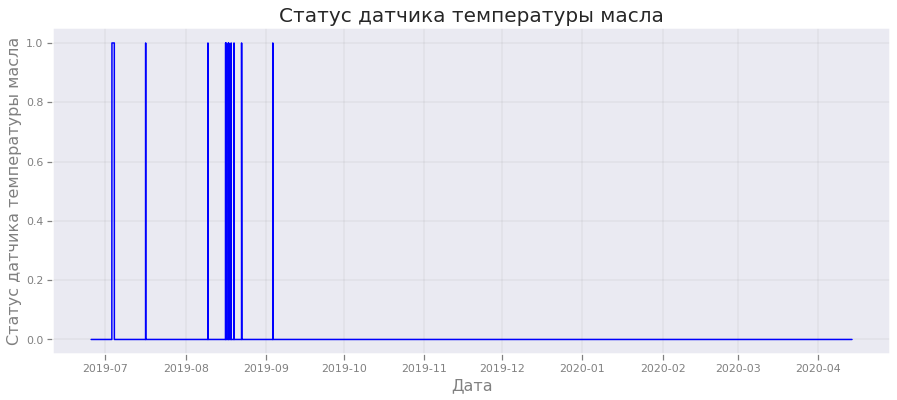

In [191]:
# Статус предупреждения индикатора (датчика) температуры масла в течение наблюдаемого периода:
plt.plot(df['DeviceTimeStamp'], df['OTI_A'], color='blue')
plt.title('Статус датчика температуры масла')
plt.xlabel('Дата')
plt.ylabel('Статус датчика температуры масла')

Сообщения датчика зафиксированы в период низкого уровня масла

Text(0, 0.5, 'Срабатывание датчика температуры масла')

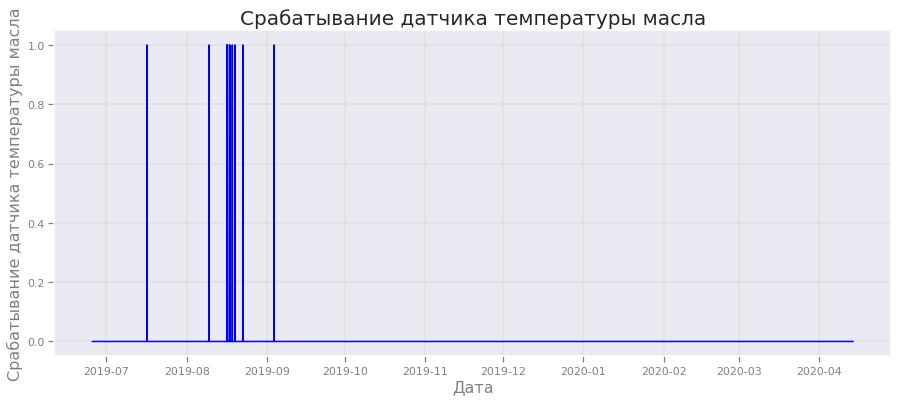

In [192]:
# Срабатывание датчика температуры масла в течение наблюдаемого периода:
plt.plot(df['DeviceTimeStamp'], df['OTI_T'], color='blue')
plt.title('Срабатывание датчика температуры масла')
plt.xlabel('Дата')
plt.ylabel('Срабатывание датчика температуры масла')

Картина по большей части повторяет предыдущую диаграмму

Text(0, 0.5, 'Сигнализатор уровня масла в баке')

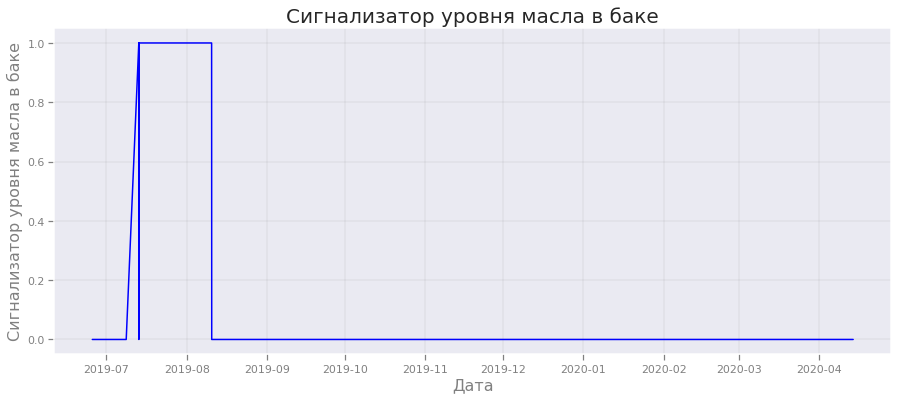

In [193]:
# Сигнализатор уровня масла в баке в течение наблюдаемого периода (целевой признак):
plt.plot(df['DeviceTimeStamp'], df['MOG_A'], color='blue')
plt.title('Сигнализатор уровня масла в баке')
plt.xlabel('Дата')
plt.ylabel('Сигнализатор уровня масла в баке')

Целевая переменная принимала положительные значения (1) в июле-августе 2019 г., что соответствует периоду с минимальным уровнем масла и аномальными скачками температуры масла

#### Подготовка данных для обучения моделей

In [194]:
# Выделение независимых и зависимого признаков
X = df.drop(['DeviceTimeStamp', 'MOG_A'], axis=1)
y = df['MOG_A']

In [195]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [196]:
# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Обучение моделей

##### Модель 1. Логистическая регрессия

In [197]:
# Инициализация и обучение модели
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [198]:
# Оценка точности модели
lr_acc_mod = accuracy_score(y_pred_lr, y_test)
lr_f1_mod = f1_score(y_test, y_pred_lr, average='binary')
print("Точность модели (accuracy_score):", round(lr_acc_mod*100, 2), "%")
print("Точность модели (F-score):", round(lr_f1_mod, 3))

Точность модели (accuracy_score): 97.13 %
Точность модели (F-score): 0.854


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

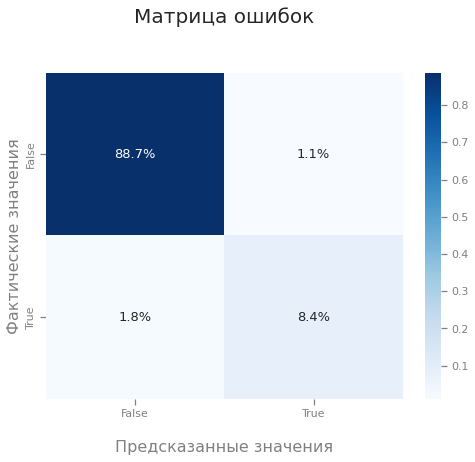

In [199]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.rcParams['figure.figsize'] = (8,6) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

##### Модель 2. Метод К ближайших соседей

In [200]:
# Инициализация и обучение модели
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [201]:
# Оценка точности модели
knn_acc_mod = accuracy_score(y_pred_knn, y_test)
knn_f1_mod = f1_score(y_test, y_pred_knn, average='binary')
print("Точность модели (accuracy score):", round(knn_acc_mod*100, 2), "%")
print("Точность модели (F-score):", round(knn_f1_mod, 3))

Точность модели (accuracy score): 94.3 %
Точность модели (F-score): 0.725


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

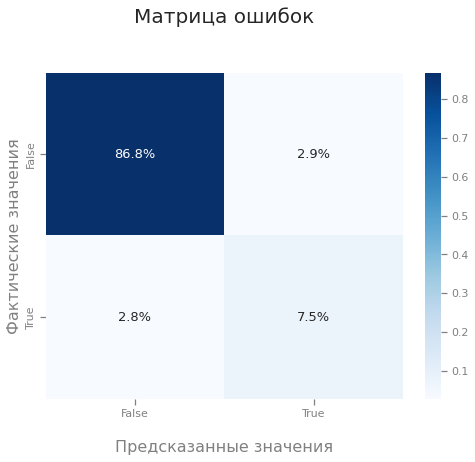

In [202]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.rcParams['figure.figsize'] = (8,6) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

##### Модель 3. Решающее дерево

In [203]:
# Инициализация и обучение модели
decision = DecisionTreeClassifier()
decision.fit(X_train, y_train)
y_pred_dec = decision.predict(X_test)

In [204]:
# Оценка точности модели
decision_acc_mod = accuracy_score(y_pred_dec, y_test)
decision_f1_mod = f1_score(y_test, y_pred_dec, average='binary')
print("Точность модели (accuracy score):", round(decision_acc_mod*100, 2), "%")
print("Точность модели (F-score):", round(decision_f1_mod, 3))

Точность модели (accuracy score): 97.91 %
Точность модели (F-score): 0.898


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

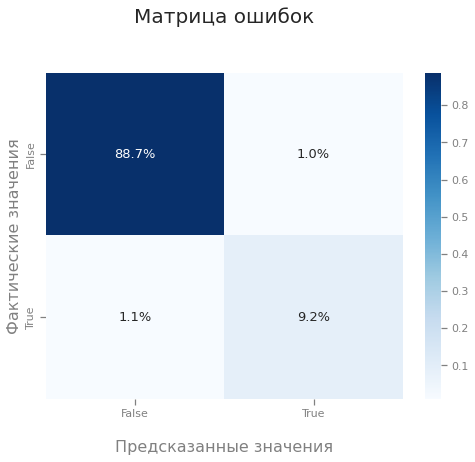

In [205]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_dec)
plt.rcParams['figure.figsize'] = (8,6) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

##### Модель 4. Чрезвычайно рандомизированные деревья

In [206]:
# Инициализация и обучение модели
x_trees = ExtraTreesClassifier()
x_trees.fit(X_train, y_train)
y_pred_x_trees = x_trees.predict(X_test)

In [207]:
# Оценка точности модели
x_trees_acc_mod = accuracy_score(y_pred_x_trees, y_test)
x_trees_f1_mod = f1_score(y_test, y_pred_x_trees, average='binary')
print("Точность модели: (accuracy score):", round(x_trees_acc_mod*100, 2), "%")
print("Точность модели (F-score):", round(x_trees_f1_mod, 3))

Точность модели: (accuracy score): 98.58 %
Точность модели (F-score): 0.932


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

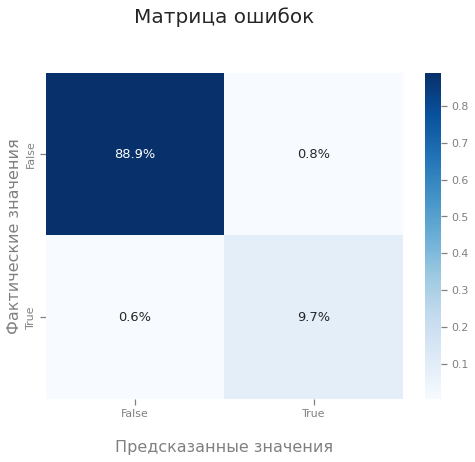

In [208]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_x_trees)
plt.rcParams['figure.figsize'] = (8,6) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

##### Модель 5. Случайный лес

In [209]:
# Инициализация и обучение модели
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

In [210]:
# Оценка точности модели
forest_acc_mod = accuracy_score(y_pred_forest, y_test)
forest_f1_mod = f1_score(y_test, y_pred_forest, average='binary')
print("Точность модели (accuracy score):", round(forest_acc_mod*100, 2), "%")
print("Точность модели (F-score):", round(forest_f1_mod, 3))

Точность модели (accuracy score): 98.51 %
Точность модели (F-score): 0.929


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

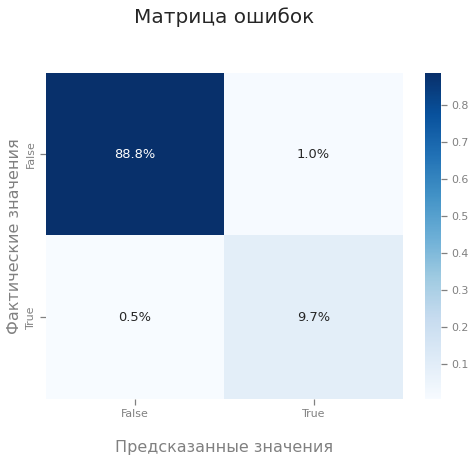

In [211]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_forest)
plt.rcParams['figure.figsize'] = (8,6) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

##### Модель 6. Метод опорных векторов

In [212]:
# Инициализация и обучение модели
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [213]:
# Оценка точности модели
svc_acc_mod = accuracy_score(y_pred_svc, y_test)
svc_f1_mod = f1_score(y_test, y_pred_svc, average='binary')
print("Точность модели (accuracy score):", round(svc_acc_mod*100, 2), "%")
print("Точность модели (F-score):", round(svc_f1_mod, 3))

Точность модели (accuracy score): 94.8 %
Точность модели (F-score): 0.705


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

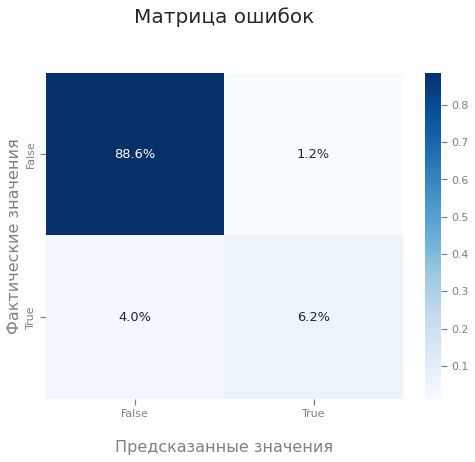

In [214]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_svc)
plt.rcParams['figure.figsize'] = (8,6) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

##### Модель 7. Экстремальный градиентный бустинг

In [215]:
# Инициализация и обучение модели
g_boost = Xgb.XGBClassifier()
g_boost.fit(X_train, y_train)
y_pred_g_boost = g_boost.predict(X_test)

In [216]:
# Оценка точности модели
g_boost_acc_mod = accuracy_score(y_pred_g_boost, y_test)
g_boost_f1_mod = f1_score(y_test, y_pred_g_boost, average='binary')
print("Точность модели (accuracy score):", round(g_boost_acc_mod*100, 2), "%")
print("Точность модели (F-score):", round(g_boost_f1_mod, 3))

Точность модели (accuracy score): 98.15 %
Точность модели (F-score): 0.912


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

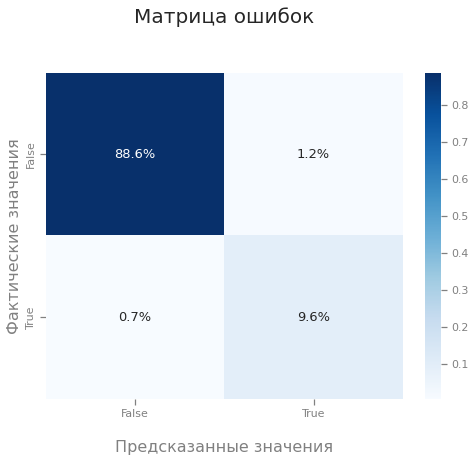

In [217]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_g_boost)
plt.rcParams['figure.figsize'] = (8,6) 
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

#### Сопоставительная оценка качества моделей

In [250]:
# создание итогового датафрейма с показателями точности моделей
df_models_acc = pd.DataFrame([round(lr_acc_mod*100, 2), round(knn_acc_mod*100, 2),\
                              round(decision_acc_mod*100, 2), round(x_trees_acc_mod*100, 2),\
                              round(forest_acc_mod*100, 2), round(svc_acc_mod*100, 2), \
                              round(g_boost_acc_mod*100, 2)], columns=['Accuracy score (%)'])
df_models_f1 = pd.DataFrame([round(lr_f1_mod, 3), round(knn_f1_mod, 3),\
                              round(decision_f1_mod, 3), round(x_trees_f1_mod, 3),\
                              round(forest_f1_mod, 3), round(svc_f1_mod, 3), \
                              round(g_boost_f1_mod, 3)], columns=['F-score'])
df_models_names = pd.DataFrame(['Logistic regression', 'KNN', 'Decision trees', 'Extra Trees',\
                                'Random Forest', 'SVC', 'XGBoosting'], columns=['Модель'])
df_comparison = pd.concat([df_models_names, df_models_acc, df_models_f1], axis=1).sort_values(by='F-score', ascending=False)
#df_comparison

df_comparison.style.bar(color='green', align="mid")

,Модель,Accuracy score (%),F-score
3,Extra Trees,98.580000,0.932000
4,Random Forest,98.510000,0.929000
6,XGBoosting,98.150000,0.912000
2,Decision trees,97.910000,0.898000
0,Logistic regression,97.130000,0.854000
1,KNN,94.300000,0.725000
5,SVC,94.800000,0.705000


Text(0, 0.5, 'F-score, %')

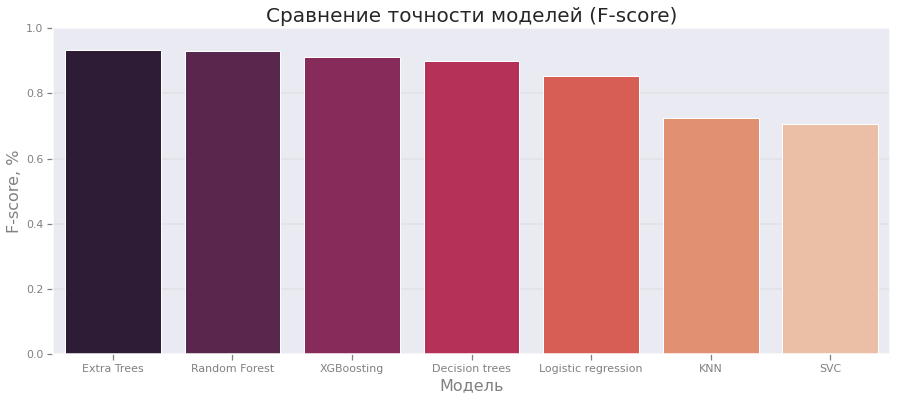

In [219]:
# визуализация итогов исследования по F-score

plt.rcParams['figure.figsize'] = (15,6) 
fig, ax = plt.subplots()
sns.barplot(
    y='F-score',
    x='Модель',
    data=df_comparison,
    palette='rocket')
ax.set_ylim(0,1)
plt.title('Сравнение точности моделей (F-score)')
plt.xlabel('Модель')
plt.ylabel('F-score, %')

**ВЫВОДЫ:**

- Наиболее точными моделями (F-score > 0.91, Accuracy score > 98%) являются модели № 4 (Extra Trees), № 5 (Random Forest) и № 7 (XGBoosting)

- Наименьшая точность (F-score < 0.73, Accuracy score < 95%) зафиксирована у моделей № 6 (SVC) и № 2 (KNN)

- Результаты моделирования позволяют с высокой точностью заблаговременно определять состояние силового трансформатора, соответствующее условиям срабатывания сигнализатора датчика масла

- Применение модели позволит **снизить вероятность повреждения** силовых трансформаторов с выбросом / возгоранием масла, а также **сопутствующего ущерба** энергокомпаний и потребителей электроэнергии

### Задача 2. Предсказание индекса технического состояния (ИТС) трансформаторов на основе контролируемых параметров

#### Загрузка данных и EDA

In [220]:
df_its = pd.read_csv('Health_index.csv')
df_its.head(3)

,Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,DBDS,Power factor,Interfacial V,Dielectric rigidity,Water content,Health index
0,2845,5860,27842,7406,32,1344,16684,5467,7,19.0,1.0,45,55,0,95.2
1,12886,61,25041,877,83,864,4,305,0,45.0,1.0,45,55,0,85.5
2,2820,16400,56300,144,257,1080,206,11,2190,1.0,1.0,39,52,11,85.3


In [221]:
df_its.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hydrogen             470 non-null    int64  
 1   Oxigen               470 non-null    int64  
 2   Nitrogen             470 non-null    int64  
 3   Methane              470 non-null    int64  
 4   CO                   470 non-null    int64  
 5   CO2                  470 non-null    int64  
 6   Ethylene             470 non-null    int64  
 7   Ethane               470 non-null    int64  
 8   Acethylene           470 non-null    int64  
 9   DBDS                 470 non-null    float64
 10  Power factor         470 non-null    float64
 11  Interfacial V        470 non-null    int64  
 12  Dielectric rigidity  470 non-null    int64  
 13  Water content        470 non-null    int64  
 14  Health index         470 non-null    float64
dtypes: float64(3), int64(12)
memory usage: 5

Пропуски отсутствуют

In [222]:
df_its.describe()

,Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,DBDS,Power factor,Interfacial V,Dielectric rigidity,Water content,Health index
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,404.261702,8357.372340,47759.561702,79.695745,244.000000,1816.414894,162.923404,81.940426,91.491489,17.036596,1.849043,38.434043,53.495745,16.282979,27.504043
std,2002.142678,14164.233283,13760.451816,489.320336,237.267485,2256.790519,1323.811504,342.573636,644.365828,46.735057,6.144009,6.178830,6.458906,17.115646,17.741458
min,0.000000,57.000000,3600.000000,0.000000,10.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.050000,21.000000,27.000000,0.000000,13.400000
25%,4.000000,496.000000,41700.000000,2.000000,66.000000,641.750000,0.000000,0.000000,0.000000,0.000000,0.570000,32.000000,51.000000,5.000000,13.400000
50%,9.000000,3810.000000,49100.000000,3.000000,150.500000,1125.000000,3.000000,4.000000,0.000000,0.000000,1.000000,39.000000,54.000000,12.000000,13.400000
75%,34.000000,14875.000000,55875.000000,7.000000,361.750000,2257.500000,6.000000,69.750000,0.000000,2.000000,1.000000,44.000000,56.000000,21.000000,38.550000
max,23349.000000,249900.000000,85300.000000,7406.000000,1730.000000,24900.000000,16684.000000,5467.000000,9740.000000,227.000000,73.200000,57.000000,75.000000,183.000000,95.200000


- По ряду признаков имеются значительные выбросы, которые, однако, наиболее вероятно носят естественный характер и являются важнейшими индикаторами целевого признака, в связи с чем, учитывая ограниченный объем выборки (470 записей), удаление выбросов проводиться не будет

- Наличие выбросов, с высокой долей вероятности, отрицательно повлияет на качество модели линейной регрессии

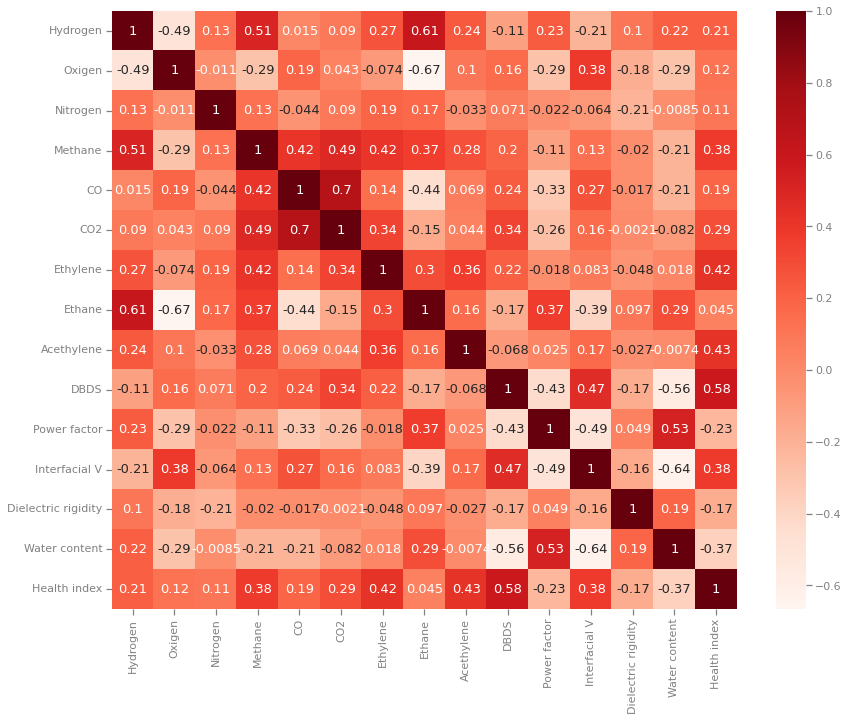

In [223]:
# определение корреляции признаков

corr = df_its.corr(method='spearman')   # используется метод Спирмена в связи с наличием выбросов

plt.figure(figsize=(14,11))
sns.heatmap(corr, annot=True, cmap='Reds')

- Коллинеарность независимых признаков, требующая исключения отдельных признаков из модели, отсутстсует

(array([263.,  22.,   4.,  66.,  86.,  17.,   3.,   4.,   4.,   1.]),
 array([13.4 , 21.58, 29.76, 37.94, 46.12, 54.3 , 62.48, 70.66, 78.84,
        87.02, 95.2 ]),
 <a list of 10 Patch objects>)

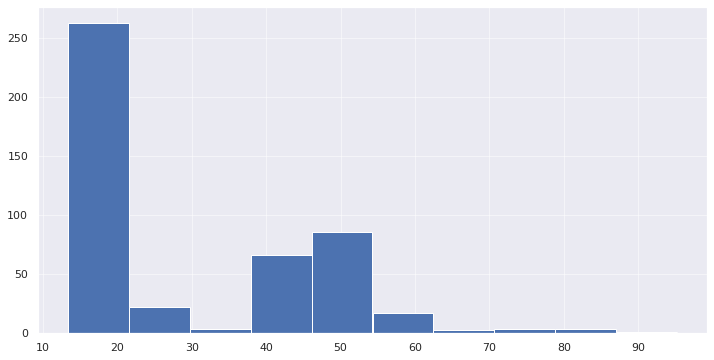

In [224]:
# гистограмма распределения зависимого признака

sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,6))
plt.hist(x='Health index', data=df_its, bins=10)

Распределение значений зависимого признака имеет ассиметричный характер с пиком в районе низких значений ИТС (до 20-22 баллов), что косвенно свидетельствует о высоком физическом износе парка силовых трансформаторов и их ухудшенном техническом состоянии

#### Подготовка данных для обучения моделей

In [225]:
# Выделение независимых и зависимого признаков
X = df_its.drop('Health index', axis=1)
y = df_its['Health index']

In [226]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [227]:
# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Обучение моделей

#### Модель 1. Линейная регрессия

In [228]:
# Инициализация и обучение модели
linr = LinearRegression()
linr.fit(X_train, y_train)

LinearRegression()

In [229]:
# значение интерсепта
linr.intercept_

26.375379939209726

In [230]:
# значения коэффициентов
linr.coef_

array([ 6.5831779 ,  0.8802675 ,  1.32023399, -0.10168871,  0.11610929,
        0.05733048,  0.1667758 , -2.99094201,  3.47242212,  6.63027889,
        1.17650054,  4.4173582 , -0.89229496, -0.49341864])

In [231]:
# создание датафрейма с коэффициентами признаков
df_coef = pd.DataFrame(linr.coef_, X.columns, columns=['Coefficient'])
df_coef

,Coefficient
Hydrogen,6.583178
Oxigen,0.880268
Nitrogen,1.320234
Methane,-0.101689
CO,0.116109
CO2,0.057330
Ethylene,0.166776
Ethane,-2.990942
Acethylene,3.472422
DBDS,6.630279


In [232]:
# оценка точности модели
y_pred_test_linr = linr.predict(X_test)
r2_score_linr = round(r2_score(y_test,y_pred_test_linr), 3)
print("Точность модели:", r2_score_linr)    # коэффициент детерминации

Точность модели: 0.148


Низкое значение коэффициента детерминации (0.148) свидетельствует о недостаточном качестве модели, основанной на линейной регрессии

In [233]:
# оценка показателей MAE, MAPE и MSE:

print("Значение MAE:", round(mae(y_test, y_pred_test_linr), 2))
print("Значение MAPE:", round(mape(y_test, y_pred_test_linr)*100, 2), '%')
print("Значение MSE:", round(mse(y_test, y_pred_test_linr), 2))

Значение MAE: 10.61
Значение MAPE: 38.69 %
Значение MSE: 312.97


Значения MAE, MAPE и MSE по показателю ИТС (измеряется по шкале от 0 до 100 баллов) подтверждают вывод о низком качестве модели линейной регрессии

#### Модель 2. Случайный лес

In [234]:
# Инициализация и обучение модели
forest = RandomForestRegressor(n_estimators=5000, random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=5000, random_state=42)

In [235]:
# оценка точности модели
y_pred_test_forest = forest.predict(X_test)
print("Точность модели (коэффициент детерминации):", round(r2_score(y_test,y_pred_test_forest), 3))

Точность модели (коэффициент детерминации): 0.733


Качество модели № 2 гораздо выше предыдущей модели, более 73% значения зависимого признака объясняется независимыми признаками, входящими в модель

#### Модель 3. Экстремальный градиентный бустинг

In [236]:
# Инициализация и обучение модели
xg_boost = XGBRegressor()
xg_boost.fit(X_train,y_train)

[08:45:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [237]:
# оценка точности модели
y_pred_test_xg_boost = xg_boost.predict(X_test)
r2_score_xgb = round(r2_score(y_test,y_pred_test_xg_boost), 3)
print("Точность модели (коэффициент детерминации):", r2_score_xgb)

Точность модели (коэффициент детерминации): 0.732


Качество модели № 3 сопоставимо с качеством модели № 2

#### Grid Search CV: подбор оптимальных параметров для модели 2

In [238]:
params_m2 = {'n_estimators': [30, 50, 70],
            'max_depth': [40, 60, 80],
            'max_features': [2, 3, 4, 5],
            'min_samples_leaf': [2, 3, 4, 5],
            'min_samples_split': [2, 4, 7, 10]}

In [239]:
grid_m2 = GridSearchCV(RandomForestRegressor(), params_m2, cv=5, n_jobs=-1, verbose=True, refit=True, scoring='r2')
grid_m2.fit(X_train,y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [40, 60, 80],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 4, 7, 10],
                         'n_estimators': [30, 50, 70]},
             scoring='r2', verbose=True)

In [240]:
grid_m2_predict_test = grid_m2.predict(X_test)

In [241]:
r2_score_rf_opt = round(r2_score(y_test,grid_m2_predict_test), 3)
print('Точность модели 2 на оптимальных параметрах:', r2_score_rf_opt)
print(f'Оптимальные параметры модели 2: {grid_m2.best_params_}')

Точность модели 2 на оптимальных параметрах: 0.75
Оптимальные параметры модели 2: {'max_depth': 60, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 30}


- В результате перебора параметров достигнуто незначительное повышение коэффициента детерминации модели № 2 (с 0.733 до 0.750)

#### Grid Search CV: подбор оптимальных параметров для модели 3

In [242]:
params_m3 = {'n_estimators': [30, 50, 70],
            'max_depth': [40, 60, 80],
            'max_features': [2, 3, 4, 5],
            'min_samples_leaf': [2, 3, 4, 5],
            'min_samples_split': [2, 4, 7, 10]}

In [243]:
grid_m3 = GridSearchCV(XGBRegressor(), params_m3, cv=5, n_jobs=-1, verbose=True, refit=True, scoring='r2')
grid_m3.fit(X_train,y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[08:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'max_depth': [40, 60, 80],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 4, 7, 10],
                         'n_estimators': [30, 50, 70]},
             scoring='r2', verbose=True)

In [244]:
grid_m3_predict_test = grid_m3.predict(X_test)

In [245]:
r2_score_xgb_opt = round(r2_score(y_test,grid_m3_predict_test), 3)
print('Точность модели 3 на оптимальных параметрах:', r2_score_xgb_opt)
print(f'Оптимальные параметры модели 3: {grid_m3.best_params_}')

Точность модели 3 на оптимальных параметрах: 0.717
Оптимальные параметры модели 3: {'max_depth': 40, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


- В результате перебора параметров не удалось достигнуть повышения коэффициента детерминации модели № 3 относительно параметров по умолчанию

#### ИТОГОВЫЕ ВЫВОДЫ ПО РАССМОТРЕННЫМ МОДЕЛЯМ ПРОГНОЗИРОВАНИЯ ЗНАЧЕНИЙ ИНДЕКСА ТЕХНИЧЕСКОГО СОСТОЯНИЯ ТРАНСФОРМАТОРОВ

In [253]:
# создание итогового датафрейма с показателями точности моделей
df_its_models_acc = pd.DataFrame([r2_score_linr, r2_score_rf_opt, r2_score_xgb], columns=['Коэффициент детерминации'])
df_its_models_names = pd.DataFrame(['Linear regression', 'Random forest', 'XGBoosting'], columns=['Модель'])
df_its_comparison = pd.concat([df_its_models_names, df_its_models_acc], axis=1).sort_values(by='Коэффициент детерминации', ascending=False)
df_its_comparison.style.bar(color='green', align="mid", vmin=0, vmax=1)

,Модель,Коэффициент детерминации
1,Random forest,0.750000
2,XGBoosting,0.732000
0,Linear regression,0.148000


Text(0, 0.5, 'Коэффициент детерминации')

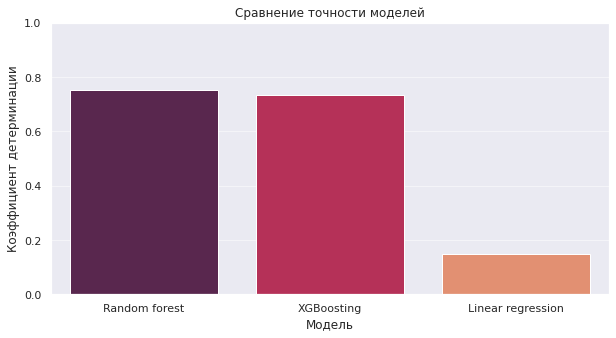

In [254]:
# визуализация итогов исследования
plt.rcParams['figure.figsize'] = (10,5) 
fig, ax = plt.subplots()
sns.barplot(
    y='Коэффициент детерминации',
    x='Модель',
    data=df_its_comparison,
    palette='rocket')
ax.set_ylim(0,1)
plt.title('Сравнение точности моделей')
plt.xlabel('Модель')
plt.ylabel('Коэффициент детерминации')

**ВЫВОДЫ:**

- **Наилучшую точность** предсказания индекса технического состояния (ИТС) трансформаторов показала **модель № 2 (Random forest)** (коэффициент детерминации 0.750)

- Сопоставимая точность зафикисрована у **модели № 3 (XGBoosting)** (коэффициент детерминации 0.732)

- Модель № 1 (линейная регрессия) непригодна для использования (коэффициент детерминации - 0.148, MAPE - 38.69%), что связано, в том числе, с наличием значительного количества естественных выбросов в данных

- Учет показателей ИТС, расчитанных по модели № 2 / № 3, при формировании производственных программ энергокомпаний позволит обеспечить своевременное планирование технических воздействий (ремонт, техническое обслуживание, замена) на трансформаторное оборудование, а также осуществить переход с планово-предупредительной системы ремонтов на ремонт силовых транформаторов по фактическому техническому состоянию